# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q paired with embedPy to carry out machine learning tasks. Below we show how to train and test a neural network model using data from the MNIST Database.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## EmbedPy

EmbedPy allows the kdb+/q interpreter to manipulate Python objects, call Python functions and load Python libraries. Python and kdb+/q developers can fuse both technologies together, allowing for a seamless application of kdb+/q’s high-speed analytics and Python’s rich ecosystem of libraries such as scikit-learn, Tensorflow, PyTorch and Theano.

## Classification Using Neural Networks

Neural Networks are machine learning models based (loosely) on biological neural networks in the brain. Data is passed through a series of layers of artificial neurons, giving increasingly useful representations. Since the number of layers can be quite large, this type of machine learning is often called deep learning.

Neural networks can:
- Work on data with little-or-no feature engineering applied.
- Be applied to perceptive problems (such as computer vision and voice recognition).

Below we implement and manipulate neural networks using Keras - a high-level API that runs on top of a number of common deep learning frameworks, including TensorFlow, Theano and CNTK.

Further discussion of neural networks can be found in the Wikipedia article [Artificial neural network](https://en.wikipedia.org/wiki/Artificial_neural_network) and more information about the Keras framework can be found on the [Keras website](https://keras.io/).

## MNIST (Handwritten Digits) Database

The [Modified National Institute of Standards and Technology (MNIST) Database](https://keras.io/datasets/), is a large collection of handwritten digits.

MNIST is commonly used for training and testing image processing systems, particularly in the field of machine learning.

<img src="images/mnist.png" />

---

### Load data

In the cell below, we load in the utilities library from the [ML-Toolkit](https://github.com/KxSystems/ml), along with graphics functions required for this notebook. We then use embedPy to import relevant python modules and load data from the MNIST database.

In [1]:
/ load toolkit and graphics functions
\l ml/ml.q
.ml.loadfile`:util/init.q

\l ../utils/graphics.q
\l ../utils/util.q

In [2]:
/ load data and split into training/testing sets
mnist:.p.import[`keras.datasets.mnist][`:load_data;<][]
d:raze(`xtrain`ytrain;`xtest`ytest)!'mnist
data:@[d;`ytrain`ytest;"f"$]

/ inspect data
-1 string[count data`xtrain]," samples of shape ",sv[" x "]string 1_ .ml.shape data`xtrain;
-1"";show 5#data`xtrain;-1"";
-1"Distribution of target values is:\n";
show update pcnt:.util.round[;.01]100*num%sum num from select num:count i by target from([]target:data`ytrain);
-1"\nTraining/test split is:\n";
show count each data;

Using TensorFlow backend.


60000 samples of shape 28 x 28

0x00000000000000000000000000000000000000000000000000000000 0x0000000000000000..
0x00000000000000000000000000000000000000000000000000000000 0x0000000000000000..
0x00000000000000000000000000000000000000000000000000000000 0x0000000000000000..
0x00000000000000000000000000000000000000000000000000000000 0x0000000000000000..
0x00000000000000000000000000000000000000000000000000000000 0x0000000000000000..

Distribution of target values is:

target| num  pcnt 
------| ----------
0     | 5923 9.87 
1     | 6742 11.24
2     | 5958 9.93 
3     | 6131 10.22
4     | 5842 9.74 
5     | 5421 9.04 
6     | 5918 9.86 
7     | 6265 10.44
8     | 5851 9.75 
9     | 5949 9.92 

Training/test split is:

xtrain| 60000
ytrain| 60000
xtest | 10000
ytest | 10000


---

### Inspect data

Before altering the data or passing it to a machine learning model, it is important to inspect the data by looking at either random single or samples of digits from the database. This can be done by either outputting or plotting each digit, shown below.

In [3]:
/ output a single random digit from the test dataset
\c 2000 2000
j:rand count data`xtest
-1"Inpecting data point ",string j;
-1"";show data[`xtest]j;-1"";
-1"Length: ",string count data[`xtest]j;
\c 16 80

Inpecting data point 5480

0x00000000000000000000000000000000000000000000000000000000
0x00000000000000000000000000000000000000000000000000000000
0x00000000000000000000000000000000000000000000000000000000
0x00000000000000000000000000000000000000000000000000000000
0x0000000000000000000000000000000000000003204cdf9603000000
0x00000000000000000000000000000000000864dcfefefefc08000000
0x00000000000000000000000000001361a6f4fefef7c06c3500000000
0x000000000000000000000000128bdafefefee36c1e00000000000000
0x000000000000000000000279dafefefbbf6a1f000000000000000000
0x0000000000000000000039fefef3bd43000000000000000000000000
0x0000000000000000000073fecc310000000000000000000000000000
0x00000000000000000000bcfe8d000000000000000000000000000000
0x00000000000000000036f2fe8d000000000000000000000000000000
0x000000000000000003b5fef22d000000000000000000000000000000
0x000000000000000053fefeea1a000000000000000000000000000000
0x000000000000000061fefefeeeb35f09000000000000000000000000
0x00000000000000000d7fc8cdfef

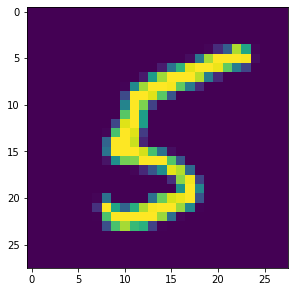

In [4]:
/ plot single digit using matplotlib
data:@[data;`xtrain`xtest;%;255]
.util.plt[`:imshow]"f"$data[`xtest]j;
.util.plt[`:show][];

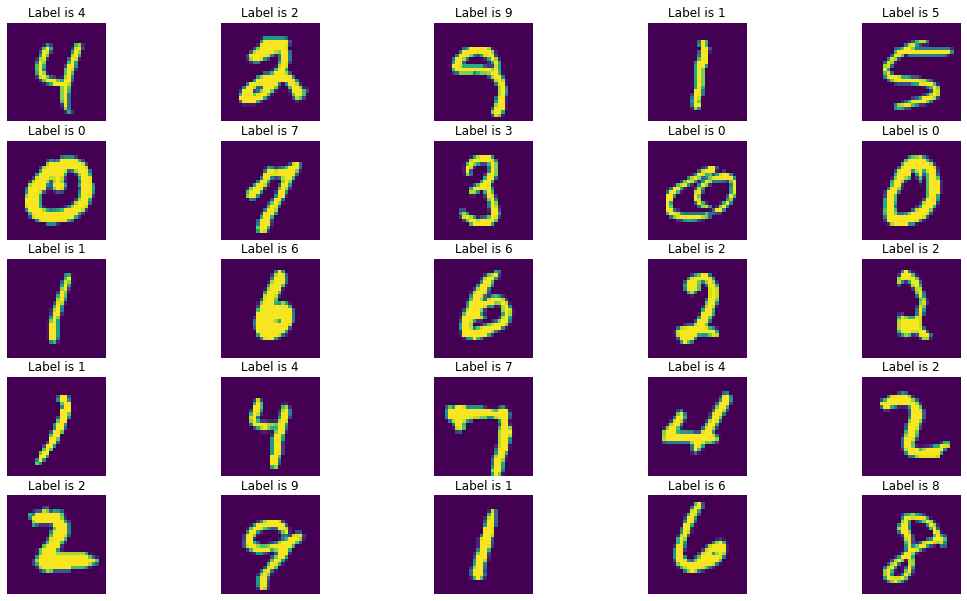

In [5]:
/ plot a random sample of digits
subplots:.util.plt[`:subplots][5;5]
fig:subplots[@;0]
axarr:subplots[@;1]
fig[`:set_size_inches;18.5;10.5];

{ i:rand count data`xtest;
  box:axarr[@;x 0][@;x 1];
  box[`:imshow]"f"$data[`xtest]i;
  box[`:axis]`off;
  box[`:set_title]"Label is ",string data[`ytest]i;
 }each cross[til 5;til 5];

.util.plt[`:show][];

---

### Prepare data

Before the raw data can be passed to the model, features must be reshaped into flattened arrays and targets one hot encoded. The inputs must also be converted to numpy arrays by using the function `.util.npa`, imported above.

In [6]:
data:@[data;`xtrain`xtest;{.util.npa[(raze/)x][`:reshape]count[x],28*28}]
data:@[data;`ytrain`ytest;{.util.npa flip value .ml.i.oneHot x}]
data  / converted into numpy arrays ready for the NN model

xtrain| {[f;x]embedPy[f;x]}[foreign]enlist
ytrain| {[f;x]embedPy[f;x]}[foreign]enlist
xtest | {[f;x]embedPy[f;x]}[foreign]enlist
ytest | {[f;x]embedPy[f;x]}[foreign]enlist


---

### Build, train and test the model

At this stage it is possible to train a neural network model. Below a sequential model and dense layers are imported from Keras and then the model is built. It is then possible to train the model using the training data, and subsequently make predictions using the testing data.

In [7]:
/ import chosen model and required layers
model:.p.import[`keras.models;`:Sequential][]
dense:.p.import[`keras.layers]`:Dense

In [8]:
/ build the model
model[`:add]dense[512;`activation pykw`relu;`input_shape pykw enlist 28*28];
model[`:add]dense[10 ;`activation pykw`softmax];
model[`:compile][`loss pykw`categorical_crossentropy;`optimizer pykw`rmsprop;`metrics pykw .p.list enlist`accuracy];
model[`:summary][];

2021-02-11 19:30:53.284059: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-02-11 19:30:53.296291: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbbe3650a40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-11 19:30:53.296345: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [9]:
/ train model
epochs:20
batchsz:128
start:.z.T
results:model[`:fit][data`xtrain;data`ytrain;`batch_size pykw batchsz;`verbose pykw 0;`epochs pykw epochs]
-1"Training continuous model for ",string[epochs]," epochs took ",string .z.T-start;

Training continuous model for 20 epochs took 00:00:33.547


In [10]:
/ make predictions using held-out testing data
preds:.ml.iMax each model[`:predict][data`xtest]`
class:first each where each 1=data[`ytest]`
show res:update Hit:Class=Prediction from([]Class:class;Prediction:preds)

Class Prediction Hit
--------------------
7     7          1  
2     2          1  
1     1          1  
0     0          1  
4     4          1  
1     1          1  
4     4          1  
9     9          1  
5     5          1  
9     9          1  
0     0          1  
..


---

### Analyzing Results
Below we compare predicted and true values to see how well the model performed.

In [11]:
/ percentage of correct vs. incorrect predictions
tot:select avg Hit by`$string Class from res
update Miss:1-Hit from tot upsert update Class:`TOTAL from select avg Hit from res

Class| Hit       Miss      
-----| --------------------
0    | 0.9897959 0.01020408
1    | 0.9903084 0.00969163
2    | 0.9864341 0.01356589
3    | 0.9881188 0.01188119
4    | 0.9786151 0.02138493
5    | 0.9764574 0.0235426 
6    | 0.9864301 0.01356994
7    | 0.979572  0.02042802
8    | 0.9784394 0.02156057
9    | 0.9653122 0.03468781
TOTAL| 0.9821    0.0179    


It is easier to understand how accuractly the model made predictions by visualizing the results. Below we show results in both a 3D plot and heatmap.

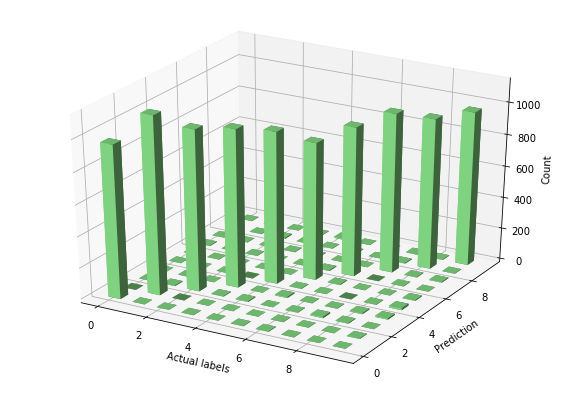

In [12]:
/ 3D plot
ctab:update pcnt:100*num%sum num by Class from select num:count i by Class,Prediction from res
ctab:0^(asc flip`Class`Prediction!flip cross[exec distinct Class from ctab;exec distinct Prediction from ctab])#ctab
ctab:0!update p:{`$"Pred_",string x}each Prediction from ctab

fig:.util.plt[`:figure][`figsize pykw 10 7]
ax:fig[`:add_subplot][111;`projection pykw"3d"];
n:count ctab
ax[`:bar3d][ctab`Class;ctab`Prediction;n#0;n#.5;n#.5;ctab`num;`color pykw`lightgreen];
ax[`:set_xlabel]"Actual labels";
ax[`:set_ylabel]"Prediction";
ax[`:set_zlabel]"Count";
.util.plt[`:show][];

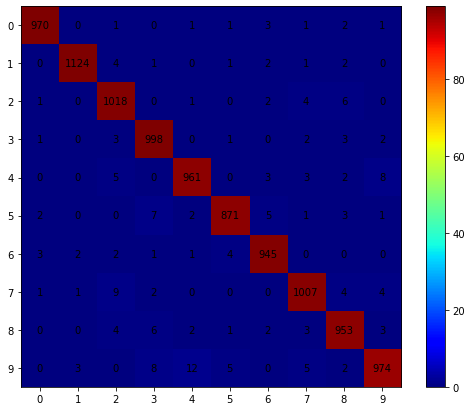

In [13]:
/ heatmap
norm_conf:flip value flip value exec(p!pcnt)by Class from ctab
fig:.util.plt[`:figure][`figsize pykw 9 7]
ax:fig[`:add_subplot]111
ax[`:set_aspect]1;

orig_cmap:.util.plt[`:get_cmap][];
.util.plt[`:set_cmap]"jet";
resIm:ax[`:imshow][norm_conf;`interpolation pykw`nearest];
ax[`:imshow][norm_conf;`interpolation pykw`nearest];
ax[`:annotate][;;`horizontalalignment pykw`center;`verticalalignment pykw`center]'[string ctab`num;flip ctab`Prediction`Class];

fig[`:colorbar]resIm;
.util.plt[`:xticks]til 10;
.util.plt[`:yticks]til 10;
.util.plt[`:show][];
.util.plt[`:set_cmap]orig_cmap;

---

### Mistakes

The results above show that the neural network model produced predictions with a high accuracy of 98% which is a great result.

The classification which seems to produce the highest rate of misclassifications is `7`. By looking more closely at the heatmap values, we see that as many as 7 `7` digits were classified as `1` and 8 were classified as `2`.

In [14]:
show hmvals:exec(p!num)by Class:Class from ctab

Class| Pred_0 Pred_1 Pred_2 Pred_3 Pred_4 Pred_5 Pred_6 Pred_7 Pred_8 Pred_9
-----| ---------------------------------------------------------------------
0    | 970    0      1      0      1      1      3      1      2      1     
1    | 0      1124   4      1      0      1      2      1      2      0     
2    | 1      0      1018   0      1      0      2      4      6      0     
3    | 1      0      3      998    0      1      0      2      3      2     
4    | 0      0      5      0      961    0      3      3      2      8     
5    | 2      0      0      7      2      871    5      1      3      1     
6    | 3      2      2      1      1      4      945    0      0      0     
7    | 1      1      9      2      0      0      0      1007   4      4     
8    | 0      0      4      6      2      1      2      3      953    3     
9    | 0      3      0      8      12     5      0      5      2      974   


These results can also be clearly displayed in a bar chart where correct classification is shown in green.

<Figure size 460.8x345.6 with 0 Axes>

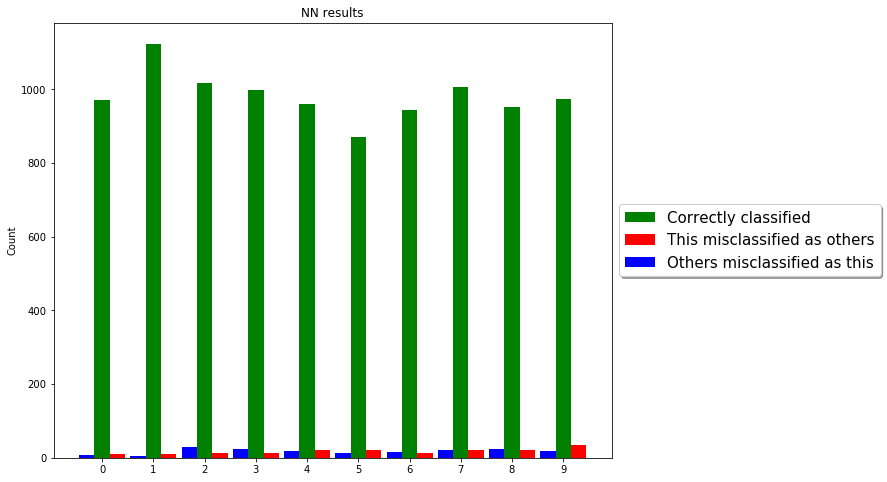

In [15]:
ind:til count cmat:flip value flip value hmvals
mclass:(corr;(sum each cmat)-corr;(sum each flip cmat)-corr:cmat ./:2#'til count cmat)
width:.3

ax:.util.plt[`:subplots][`figsize pykw 10 8][@;1]
ax[`:bar][ind;mclass 0;width;`color pykw"g";`label pykw"Correctly classified"];
ax[`:bar][ind+width;mclass 1;width;`color pykw"r";`label pykw"This misclassified as others"];
ax[`:bar][ind-width;mclass 2;width;`color pykw"b";`label pykw"Others misclassified as this"];

ax[`:set_ylabel]"Count";
ax[`:set_title]"NN results";
ax[`:set_xticks]ind;
ax[`:set_xticklabels]ind;
ax[`:legend][`loc pykw"center left";`shadow pykw 1b;`bbox_to_anchor pykw(1,0.5);`fontsize pykw 15];
.util.plt[`:show][];

We can also view the individual digits that were misclassified to try and understand where the model went wrong.

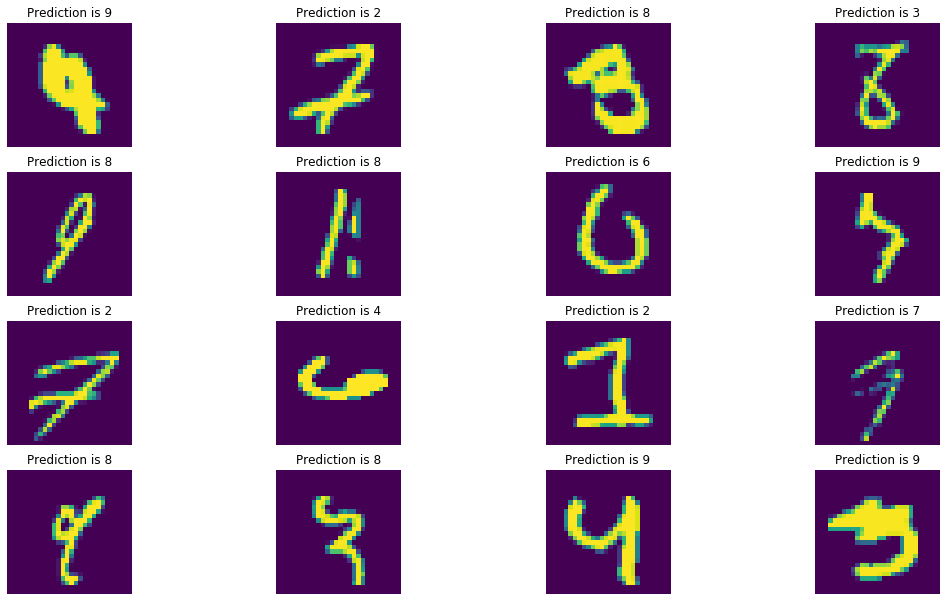

In [16]:
mistakes:16?exec i from res where not Hit

subplots:.util.plt[`:subplots][4;4]
fig:subplots[@;0]
axarr:subplots[@;1]
fig[`:set_size_inches][18.5;10.5];

{[x;i]
  box:axarr[@;x 0][@;x 1];
  box[`:imshow]28 28#255*data[`xtest][`]i;
  box[`:axis]`off;
  box[`:set_title]"Prediction is ",string res[i;`Prediction];
 }'[cross[til 4;til 4];mistakes];

.util.plt[`:show][];

---